In [1]:
import numpy as np
import pandas as pd
import uproot
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
#!pip install mplhep
#!pip install lz4 xxhash
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib
matplotlib.rcParams['figure.dpi'] = 96

In [3]:
def load_files(filepaths, treename='Events', filter_name=None, selection=None):
    import glob
    dfs = []
    if not isinstance(filepaths, (list, tuple)):
        filepaths = [filepaths]
    filepaths = sum([glob.glob(fp) for fp in filepaths], [])
    for fp in filepaths:
        df = uproot.open(fp)[treename].arrays(library='pd', filter_name=filter_name)
        if selection is not None:
            df = df.query(selection)
        dfs.append(df)
    return pd.concat(dfs)

In [4]:
def bkg_rej(tpr, fpr, eff=0.5):
    idx = next(idx for idx, v in enumerate(tpr) if v>eff)
#     print('tpr=%.3f, fpr=%.6f, 1/fpr=%.2f'%(tpr[idx], fpr[idx], 1/fpr[idx]))
    rej = 1/fpr[idx]
    return rej

In [5]:
def plot(comp_list, title='ROC Curve', savename='testfig.png', comp_text='', eff_wps=[0.5,]):
    
    colours = {
        "Xbb vs QCD" : u'#1f77b4',
#        "b vs g" : u'#ff7f0e',
        "Xcc vs QCD" : u'#2ca02c',
#        "c vs g" : u'#d62728',
        "Xqq vs QCD" : u'#9467bd',
        "2prong vs QCD" : u'#ff7f0e',
#        "b vs c" : u'#ff7f0e'
    }
    debug = True
    
    aucs = {}
    idx = 0
    f, ax = plt.subplots()


    for name, cfg in comp_list.items():
        if debug: print(name)
        if debug: print(cfg)
        bkgrejs = {}
        if len(cfg['label']) == 6:
            sig = cfg['label'][0]
            bkgBB = cfg['label'][1]
            bkgCC = cfg['label'][2]
            bkgB = cfg['label'][3]
            bkgC = cfg['label'][4]
            bkgOthers = cfg['label'][5]
            sel = f"{cfg.get('selection')} & ({sig}==1 | {bkgBB}==1 | {bkgCC}==1 | {bkgB}==1 | {bkgC}==1 | {bkgOthers}==1)"
        else:
            sigBB = cfg['label'][0]
            sigCC = cfg['label'][1]
            sigQQ = cfg['label'][2]
            bkgBB = cfg['label'][3]
            bkgCC = cfg['label'][4]
            bkgB = cfg['label'][5]
            bkgC = cfg['label'][6]
            bkgOthers = cfg['label'][7]
            sel = f"{cfg.get('selection')} & ({sigBB}==1 | {sigCC}==1 | {sigQQ}==1 | {bkgBB}==1 | {bkgCC}==1 | {bkgB}==1 | {bkgC}==1 | {bkgOthers}==1)"

        df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
                        filter_name=cfg.get('filter_name'), selection=sel)
        if debug: print(name, cfg['score'], sel, len(df), sep=",")

        # if math.isnan(df.eval(cfg['score'])):
        #     print("Debugging, score divide by 0")
        #     cfg['score'] = '0'


        if len(cfg['label']) == 6:
            y_true = df[sig].values
        else:
            y_true = df[sigBB].values | df[sigCC].values | df[sigQQ].values
            print("sigBB:")
            print(df[sigBB].values)
            print("sigCC:")
            print(df[sigCC].values)
            print("sigQQ:")
            print(df[sigQQ].values)
            print("y_true:")
            print(y_true)
        # y_true = df[sig].values

        y_pred = df.eval(cfg['score'])
        print("y_pred:")
        print(y_pred)
        print("y_true:")
        print(y_true)

        # Debugging NaN values
        # print("len(y_truth)="+str(len(y_true)))
        # print("len(y_pred)="+str(len(y_pred)))
        
        y_pred[np.isnan(y_pred)] = 0

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        aucs[idx] = auc
        idx += 1
        
        colour = [c for l, c in colours.items() if l in name][0]
        if debug: print(colour)
        style = '-'
        # style = '-' if "FULL" in name.upper() else '--'
        if debug: print(style)

        ax.plot(fpr, tpr, style, label='%s (AUC = %.4f)'%(name, auc), color=colour)

        for wp in eff_wps:
            bkgrejs[wp] = bkg_rej(tpr, fpr, wp)

        if debug: print(' - ', name, auc, [bkgrejs[wp] for wp in eff_wps], sep=',')
        
    #order = dict(sorted(aucs.items(), key=lambda item: item[1])).keys()
    #handels, labels = plt.gca().get_legend_handles_labels()
    
    #ax.legend([handels[idx] for idx in order],[labels[idx] for idx in order], loc='best', fontsize=16)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="Random Chance")
    
    ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    # ax.set_xscale('log')
    ax.set_xlim(1e-5 if auc > 0.999 else 1e-4, 1)
    ax.set_ylim(0.9 if auc > 0.999 else 0, 1)
    ax.set_ylabel('Signal efficiency', horizontalalignment='right', x=1.0)
    ax.set_xlabel('Background efficiency', horizontalalignment='right', y=1.0)
    ax.text(0.03, 0.95, comp_text, transform=ax.transAxes, fontsize=20, weight='bold')
    plt.title(title)
    plt.savefig(savename, bbox_inches='tight')
    



In [6]:
# Score Plot

def ScorePlot(comp_list, title='Scores', savename='testfig.png', comp_text=''):
    
    colours = {
        "Xbb vs QCD" : u'#1f77b4',
#        "b vs g" : u'#ff7f0e',
        "Xcc vs QCD" : u'#2ca02c',
#        "c vs g" : u'#d62728',
        "Xqq vs QCD" : u'#9467bd',
        "2prong vs QCD" : u'#ff7f0e',
#        "b vs c" : u'#ff7f0e'
    }
    debug = True
    
    f, ax = plt.subplots()

    prob_scores = {}
    idx = 0

    for name, cfg in comp_list.items():
        if debug: print(name)
        if debug: print(cfg)
        bkgrejs = {}
        if len(cfg['label']) == 6:
            sig = cfg['label'][0]
            bkgBB = cfg['label'][1]
            bkgCC = cfg['label'][2]
            bkgB = cfg['label'][3]
            bkgC = cfg['label'][4]
            bkgOthers = cfg['label'][5]
            sel = f"{cfg.get('selection')}"
        else:
            sigBB = cfg['label'][0]
            sigCC = cfg['label'][1]
            sigQQ = cfg['label'][2]
            bkgBB = cfg['label'][3]
            bkgCC = cfg['label'][4]
            bkgB = cfg['label'][5]
            bkgC = cfg['label'][6]
            bkgOthers = cfg['label'][7]
            sel = f"{cfg.get('selection')}"

        df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
                        filter_name=cfg.get('filter_name'), selection=sel)
        if debug: print(name, cfg['score'], sel, len(df), sep=",")

        y_pred = df.eval(cfg['score'])
        # print("y_pred:")
        # print(y_pred)
        print("Scores:")
        print(y_pred)
        # Debugging NaN values
        y_pred[np.isnan(y_pred)] = 0


        colour = [c for l, c in colours.items() if l in name][0]
        if debug: print(colour)
        style = '-'
        # style = '-' if "FULL" in name.upper() else '--'
        if debug: print(style)

        quark_score = ax.hist(y_pred, np.linspace(0, 1, 101), label=name, alpha=0.8, color=colour, histtype='step')

#        prob_scores[idx] = plt.hist(y_pred, np.linspace(0, 1, 101))

#        print(prob_scores[idx])
        
#        plt.plot(prob_scores[idx], color=colour, label=name)
        idx += 1

    # ax.show()
        
    # ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="Random Chance")
    
    ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    ax.set_yscale('log')
    plt.title(title)
    plt.savefig(savename, bbox_inches='tight')
    # ax.set_xlim(1e-5 if auc > 0.999 else 1e-4, 1)
    # ax.set_ylim(0.9 if auc > 0.999 else 0, 1)
    # ax.set_ylabel('Signal efficiency', horizontalalignment='right', x=1.0)
    # ax.set_xlabel('Background efficiency', horizontalalignment='right', y=1.0)
    # ax.text(0.03, 0.95, comp_text, transform=ax.transAxes, fontsize=20, weight='bold')
    # plt.title(title)
    # plt.savefig(savename, bbox_inches='tight')
    



In [7]:
# Prob Plot

def ProbPlot(comp_list, title='Prob Scores', savename='testfig.png', comp_text=''):
    
    colours = {
        "Xbb" : u'#1f77b4',
        "Xcc" : u'#2ca02c',
        "Xqq" : u'#9467bd',
        "QCDbb" : u'#ff8f1e',
        "QCDcc" : u'#ef6f2e',
        "QCDb" : u'#de7f3e',
        "QCDc" : u'#cf3f4e',
        "QCDothers" : u'#bf705e',
    }
    debug = True
    
    f, ax = plt.subplots()

    prob_scores = {}
    idx = 0

    for name, cfg in comp_list.items():
        # if debug: print(name)
        # if debug: print(cfg)
        bkgrejs = {}
        if len(cfg['label']) == 6:
            sig = cfg['label'][0]
            bkgBB = cfg['label'][1]
            bkgCC = cfg['label'][2]
            bkgB = cfg['label'][3]
            bkgC = cfg['label'][4]
            bkgOthers = cfg['label'][5]
            sel = f"{cfg.get('selection')}"
        else:
            sigBB = cfg['label'][0]
            sigCC = cfg['label'][1]
            sigQQ = cfg['label'][2]
            bkgBB = cfg['label'][3]
            bkgCC = cfg['label'][4]
            bkgB = cfg['label'][5]
            bkgC = cfg['label'][6]
            bkgOthers = cfg['label'][7]
            sel = f"{cfg.get('selection')}"

        df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
                        filter_name=cfg.get('filter_name'), selection=sel)
        if debug: print(name, cfg['score'], sel, len(df), sep=",")

        #prob_score = df['score_probXqq']
        prob_score = df.eval(cfg['score'])
        # print("y_pred:")
        # print(y_pred)

        print("prob_score:")
        print(prob_score)

        colour = [c for l, c in colours.items() if l in name][0]
        if debug: print(colour)
        style = '-'
        # style = '-' if "FULL" in name.upper() else '--'
        if debug: print(style)

        prob_hist = ax.hist(prob_score, np.linspace(0, 1, 101), label=name, alpha=0.8, color=colour, histtype='step')

#        prob_scores[idx] = plt.hist(y_pred, np.linspace(0, 1, 101))

#        print(prob_scores[idx])
        
#        plt.plot(prob_scores[idx], color=colour, label=name)
        idx += 1

    # ax.show()
        
    # ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="Random Chance")
    
    ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    ax.set_yscale('log')
    plt.title(title)
    plt.savefig(savename, bbox_inches='tight')
    # ax.set_xlim(1e-5 if auc > 0.999 else 1e-4, 1)
    # ax.set_ylim(0.9 if auc > 0.999 else 0, 1)
    # ax.set_ylabel('Signal efficiency', horizontalalignment='right', x=1.0)
    # ax.set_xlabel('Background efficiency', horizontalalignment='right', y=1.0)
    # ax.text(0.03, 0.95, comp_text, transform=ax.transAxes, fontsize=20, weight='bold')
    # plt.title(title)
    # plt.savefig(savename, bbox_inches='tight')
    



In [8]:
# Loss Plot

def LossPlot(train_log, title='Loss Curve', savename='testfig.png', trend=False):
    ifile = open(train_log, "r")
    loss_values = []
    validation_values = []
    for line in ifile:
        if "AvgLoss" in line:
            loss = line.split(", AvgAcc")
            loss = loss[0].split("AvgLoss: ")
            loss_values.append(float(loss[1]))
        # if "Current validation metric" in line:
        #     val_loss = line.split(" (best")
        #     val_loss = val_loss[0].split("metric: ")
        #     validation_values.append(float(val_loss[1]))
  #  print(loss_values)
    if trend == False:
        plt.plot(np.array(loss_values), label="Training Loss")
        # plt.plot(np.array(validation_values), label="Validation Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(bbox_to_anchor=(1.04,1), loc="best")
        plt.title(title)
        plt.savefig(savename, bbox_inches='tight')
    else:
        loss_trend = []
        for i in range(0,len(loss_values)-1):
            loss_trend.append(loss_values[i+1]-loss_values[i])
  #      print(loss_trend)
        plt.plot(np.array(loss_trend))
    #    plt.plot([0, 0], [len(loss_trend), 0], linestyle="--", lw=2, color="k", label="Random Chance")
        plt.axhline(y=0, linestyle="--", lw=2, color="k", label="Random Chance")
        plt.ylabel("Loss Trend")
        plt.xlabel("Epoch")
        plt.title(title)
        plt.savefig(savename, bbox_inches='tight')

In [9]:
# Accuracy Plot

def AccPlot(train_log, title='Accuracy Curve', savename='testfig.png'):
    ifile = open(train_log, "r")
    acc_values = []
    validation_values = []
    for line in ifile:
        if "AvgAcc" in line:
            acc = line.split("AvgAcc: ")
            acc_values.append(float(acc[1]))
        if "Current validation metric" in line:
            val_acc = line.split(" (best")
            val_acc = val_acc[0].split("metric: ")
            validation_values.append(float(val_acc[1]))
  #  print(loss_values)
    plt.plot(np.array(acc_values), label="Training Accuracy")
    plt.plot(np.array(validation_values), label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1.04,1), loc="best")
    plt.title(title)
    plt.savefig(savename, bbox_inches='tight')


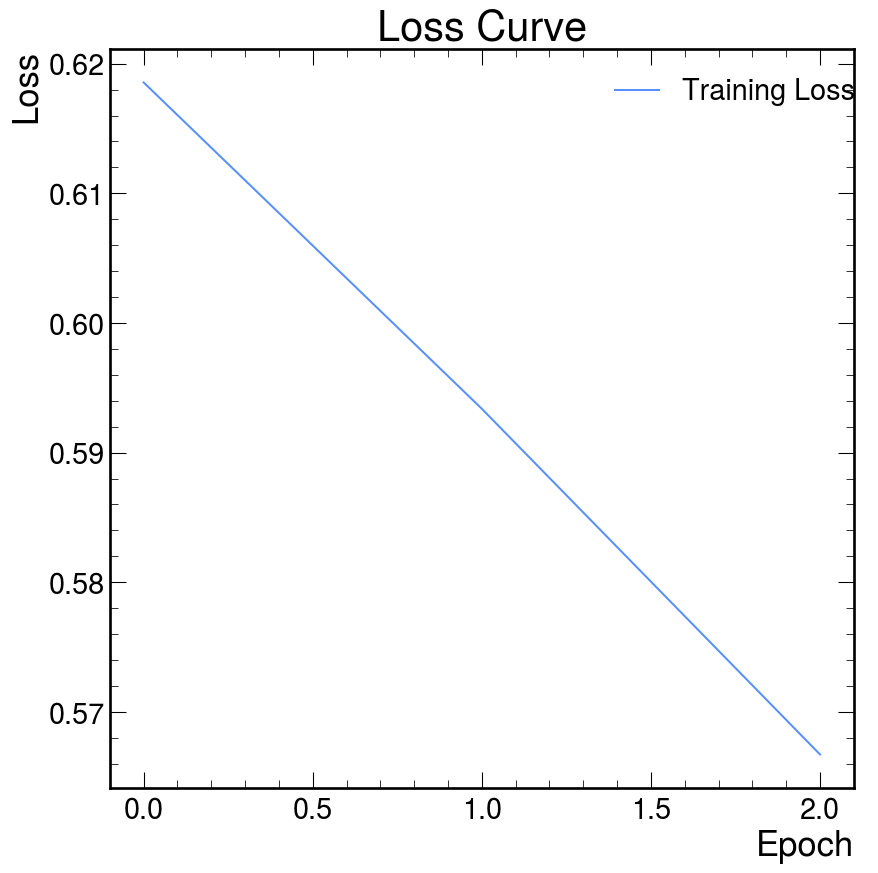

In [10]:
LossPlot("/scratch365/cmoore24/weaver-core/my_attempt/output/train.log", "Loss Curve", "test_v7_loss_curve.png")

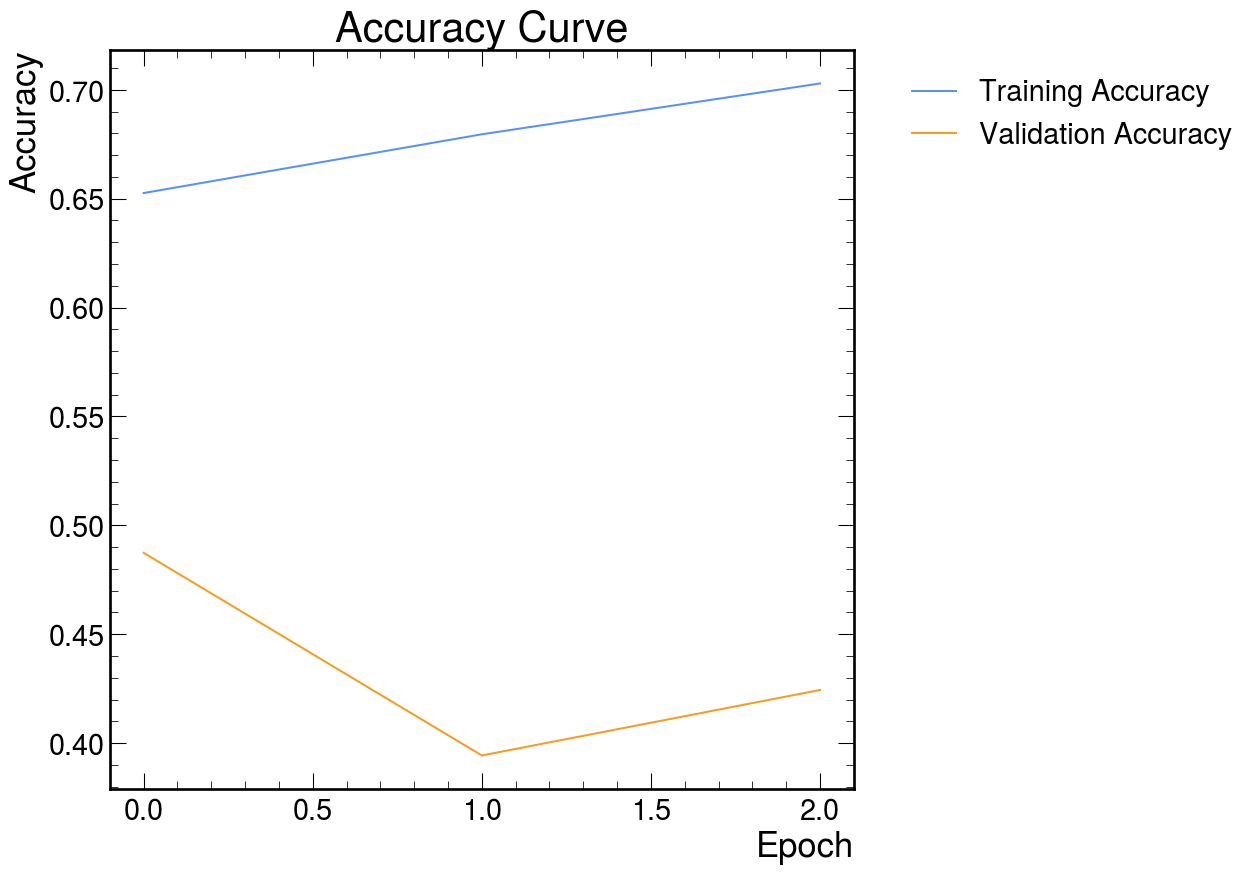

In [11]:
AccPlot("/scratch365/cmoore24/weaver-core/my_attempt/output/train.log", "Accuracy Curve", "test_v7_acc_curve.png")


Xbb vs QCD
{'filepath': '/scratch365/cmoore24/weaver-core/my_attempt/output/test8.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)', 'selection': 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}


ValueError: No objects to concatenate

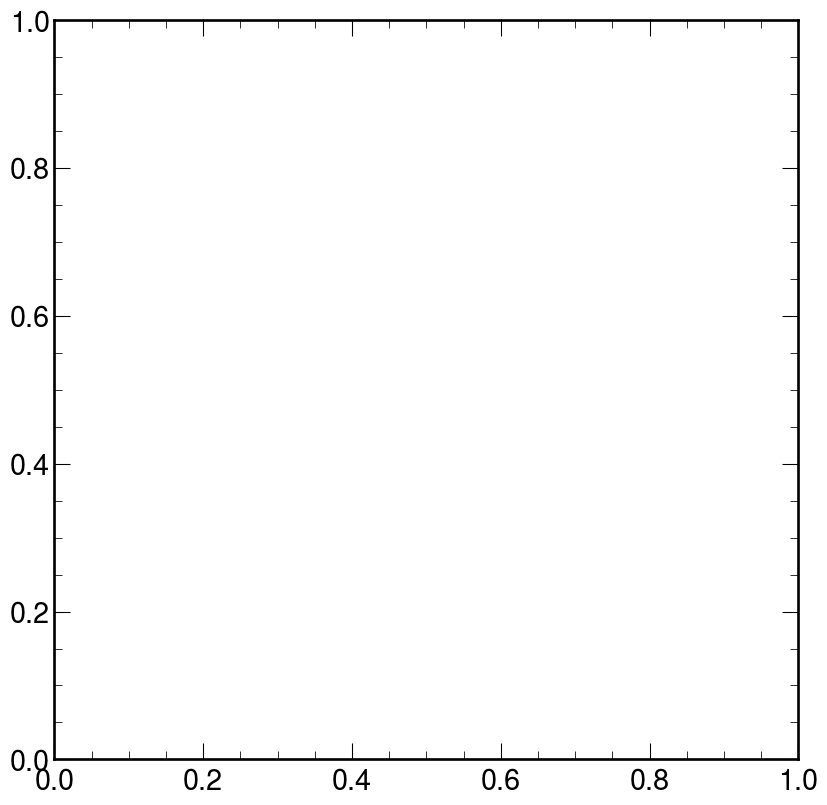

In [12]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/scratch365/cmoore24/weaver-core/my_attempt/output/test8.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

plot(algos, title='ROC Curve: Retrain, pT>110', savename='retrain_M150_best_v7_pt110.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)', 'selection': 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers),fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
Scores:
0         0.056885
1         0.000218
2         0.019971
3         0.018935
4         0.166196
            ...   
251528    0.115907
251529    0.006413
251530    0.424249
251531    0.249294
251532    0.000169
Length: 251533, dtype: float32
#1f77b4
-
Xcc vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXcc', 'pro

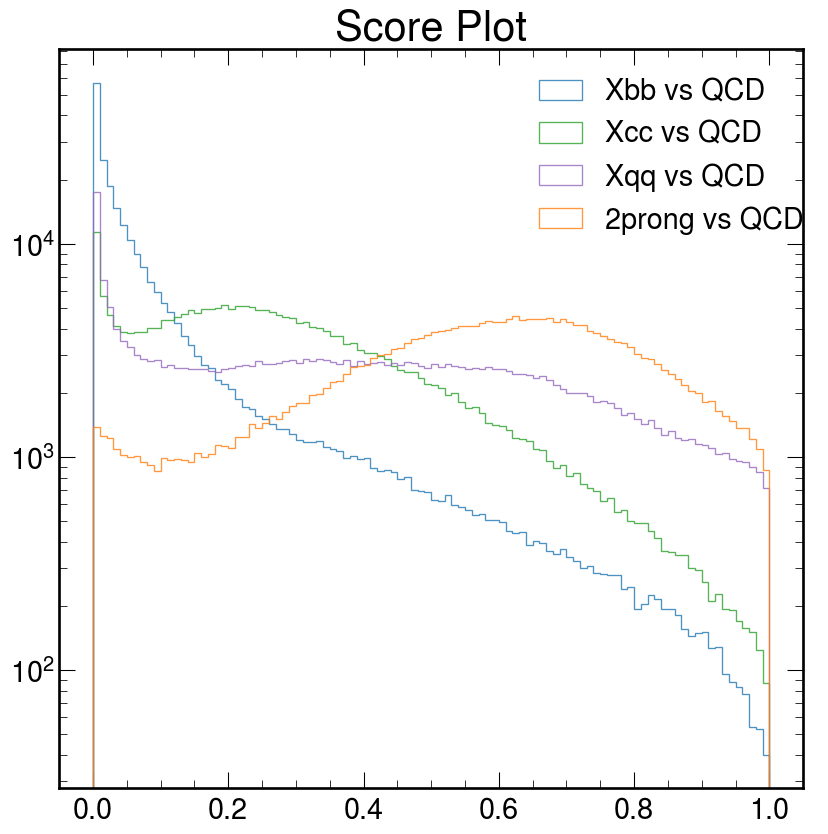

In [13]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

ScorePlot(algos, title='Score Plot', savename='retrain_M150_best_v7_pt110_scores.png')

probXbb,score_probXbb,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.015290
1         0.000209
2         0.011747
3         0.001106
4         0.062002
            ...   
251528    0.008598
251529    0.004389
251530    0.197945
251531    0.153000
251532    0.000159
Length: 251533, dtype: float32
#1f77b4
-
probXcc,score_probXcc,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.159734
1         0.008002
2         0.113879
3         0.062786
4         0.349865
            ...   
251528    0.096925
251529    0.050888
251530    0.397974
251531    0.275760
251532    0.025763
Length: 251533, dtype: float32
#2ca02c
-
probXqq,score_probXqq,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.571477
1         0.034021
2         0.297914
3         0.878813
4         0.277068
            ...   
251528    0.828892
251529 

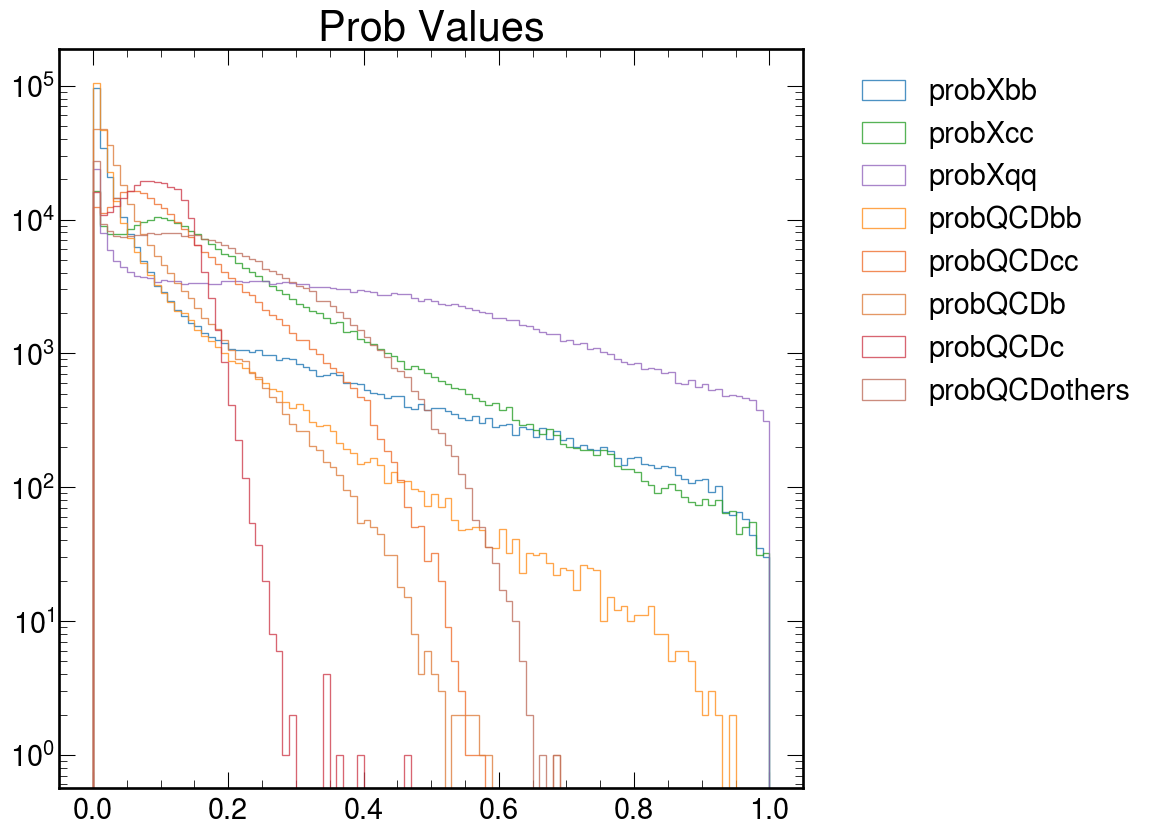

In [14]:
sigs = ["Xbb", "Xcc", "Xqq"]

bkgs = ["bb", "cc", "b", "c", "others"]

algos = {}

for sig in sigs:
    
    algos[f'prob{sig}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }
for bkg in bkgs:
    
    algos[f'probQCD{bkg}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'probQCD{bkg}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_probQCD{bkg}',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }


ProbPlot(algos, title='Prob Values', savename='retrain_M150_best_v7_pt110_probs.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)', 'selection': 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers),fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250 & (probXbb==1 | probQCDbb==1 | probQCDcc==1 | probQCDb==1 | probQCDc==1 | probQCDothers==1),52437
y_pred:
2         0.019971
3         0.018935
14        0.021986
16        0.096284
19        0.416413
            ...   
251505    0.001422
251518    0.254216
251519    0.000202
251520    0.004494
251532    0.000169
Length: 52437, dtype: float32
y_true:
[False False False ... Fals

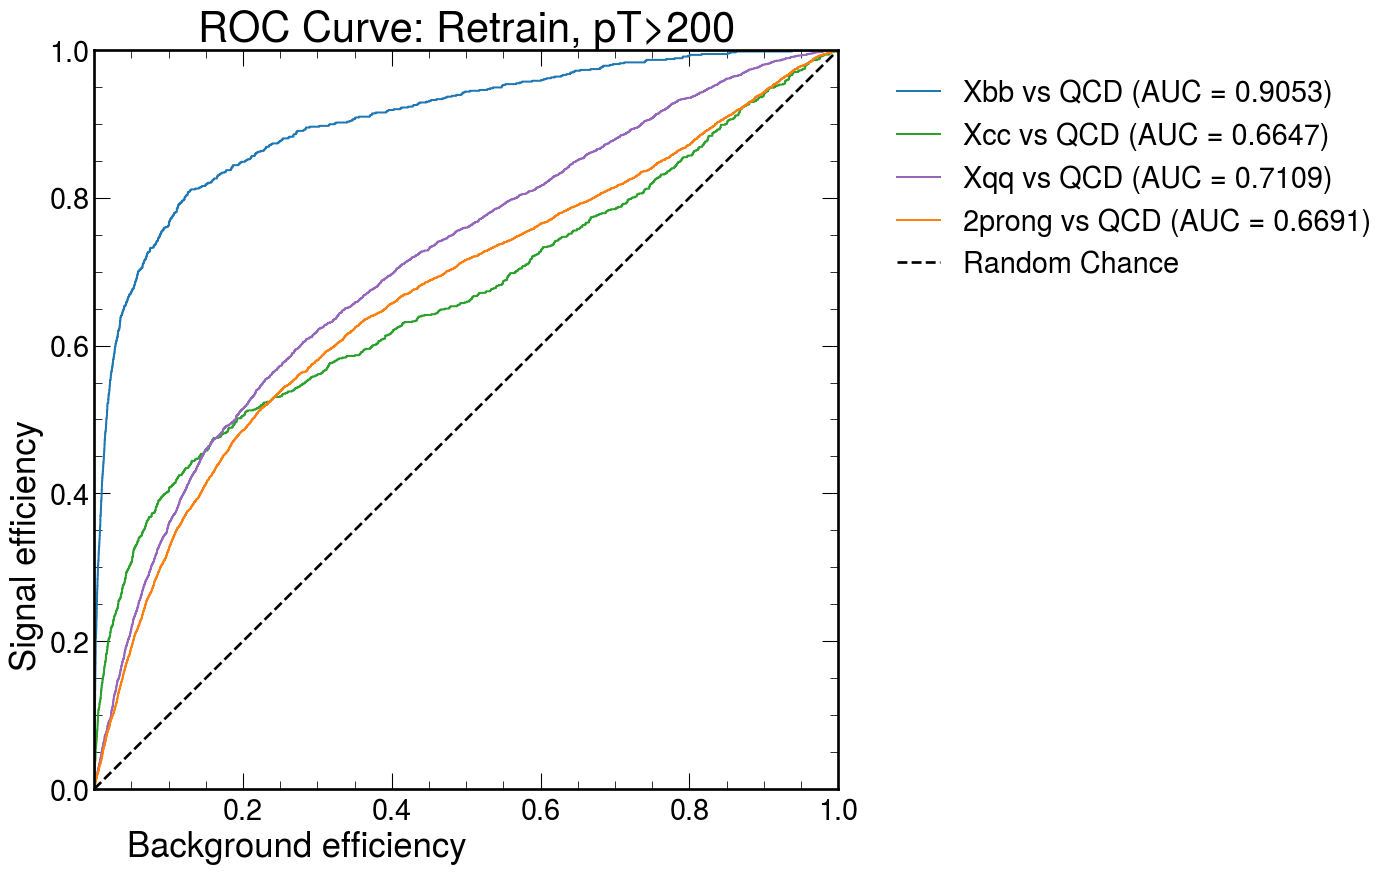

In [15]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4  & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

plot(algos, title='ROC Curve: Retrain, pT>200', savename='retrain_M150_best_v7_pt200.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)', 'selection': 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,score_probXbb/(score_probXbb + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers),fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
Scores:
2         0.019971
3         0.018935
14        0.021986
16        0.096284
19        0.416413
            ...   
251505    0.001422
251518    0.254216
251519    0.000202
251520    0.004494
251532    0.000169
Length: 56133, dtype: float32
#1f77b4
-
Xcc vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXcc', 'probQ

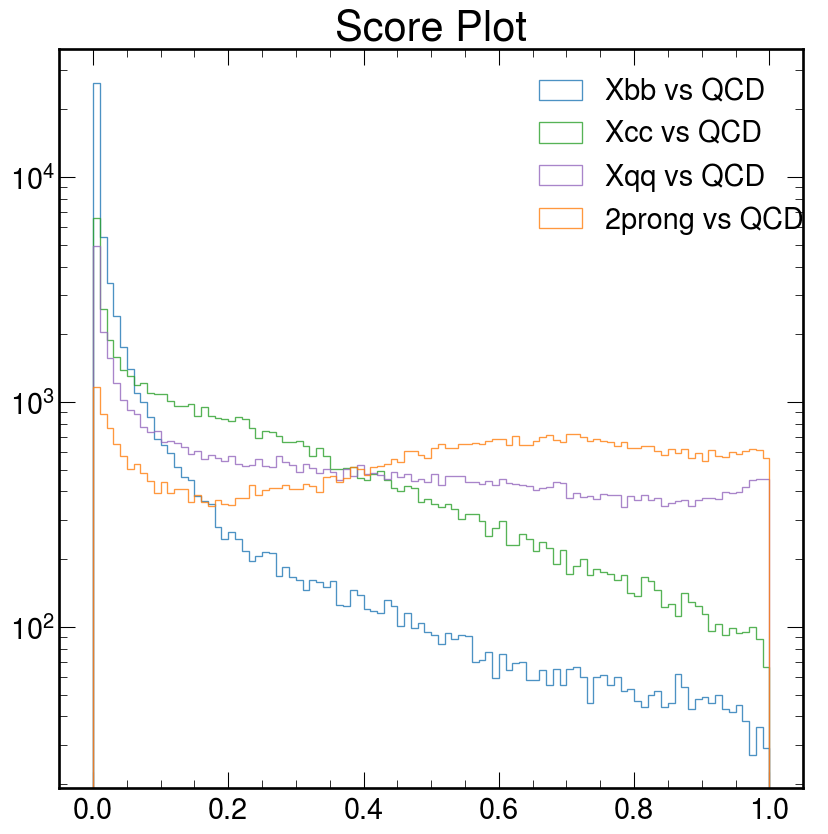

In [16]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

ScorePlot(algos, title='Score Plot', savename='retrain_M150_best_v7_pt200_scores.png')

probXbb,score_probXbb,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.011747
3         0.001106
14        0.013377
16        0.060661
19        0.319028
            ...   
251505    0.000862
251518    0.094407
251519    0.000166
251520    0.002937
251532    0.000159
Length: 56133, dtype: float32
#1f77b4
-
probXcc,score_probXcc,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.113879
3         0.062786
14        0.035637
16        0.164250
19        0.137291
            ...   
251505    0.230613
251518    0.235944
251519    0.016852
251520    0.101477
251532    0.025763
Length: 56133, dtype: float32
#2ca02c
-
probXqq,score_probXqq,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.297914
3         0.878813
14        0.355928
16        0.205725
19        0.096575
            ...   
251505    0.163351
251518    0.

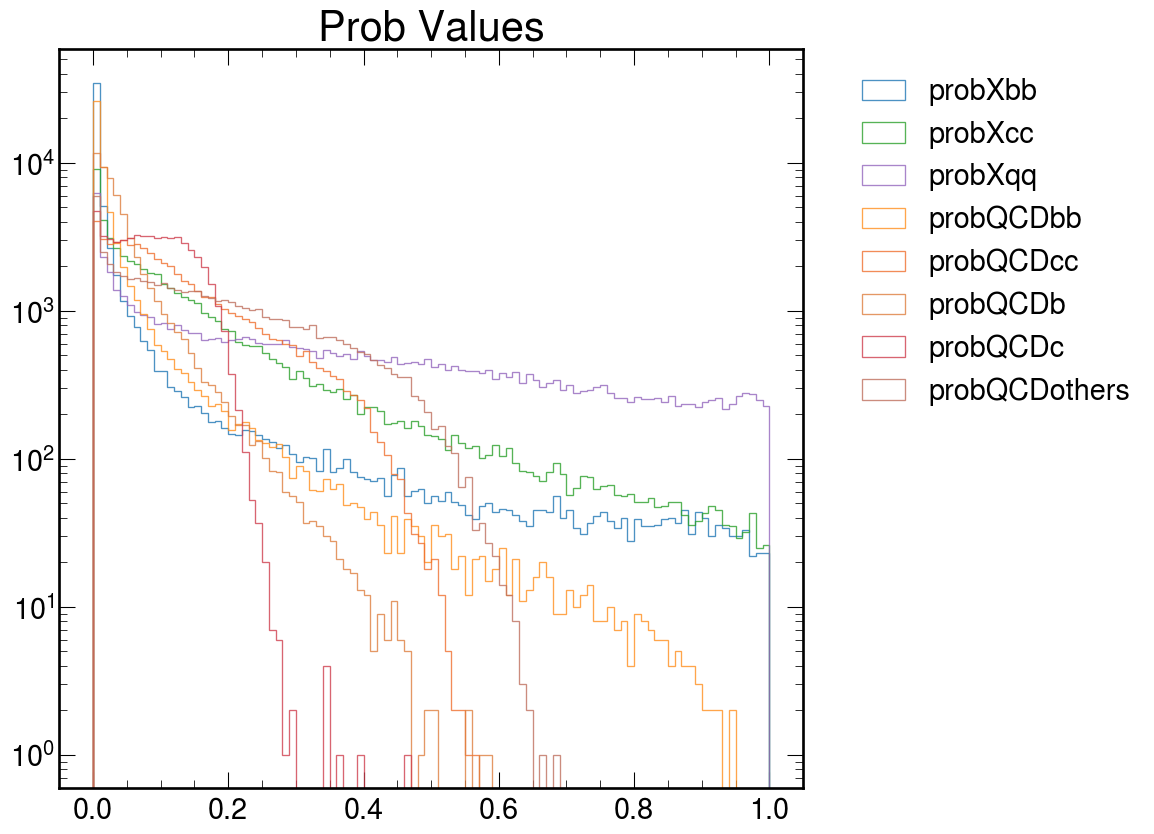

In [17]:
sigs = ["Xbb", "Xcc", "Xqq"]

bkgs = ["bb", "cc", "b", "c", "others"]

algos = {}

for sig in sigs:
    
    algos[f'prob{sig}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_prob{sig}',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }
for bkg in bkgs:
    
    algos[f'probQCD{bkg}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'probQCD{bkg}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'score_probQCD{bkg}',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }


ProbPlot(algos, title='Prob Values', savename='retrain_M150_best_v7_pt200_probs.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)', 'selection': 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers),fj_pt>110 & fj_eta>-2.4 &

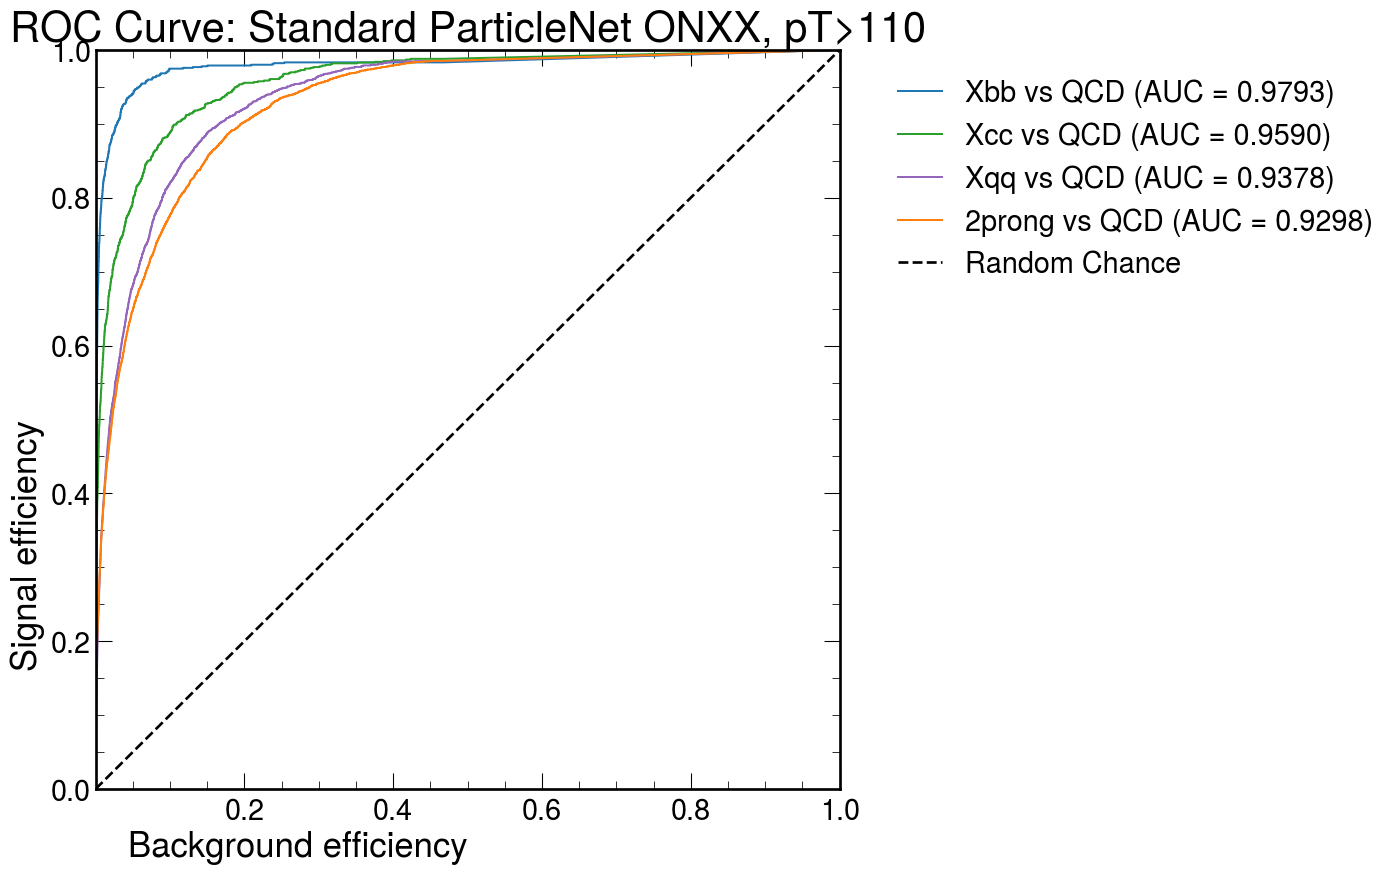

In [18]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        # 'filepath' : '/home/akobert/ParticleNet/training/output/standard6_onnx.root',
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        # 'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}/(pfMassDecorrelatedParticleNetJetTags_prob{sig} + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    # 'filepath' : '/home/akobert/ParticleNet/training/output/standard6_onnx.root',
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    # 'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'score' : '(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq)/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
    'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

plot(algos, title='ROC Curve: Standard ParticleNet ONXX, pT>110', savename='smallTest_standard_M150_best_pt110.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)', 'selection': 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers),fj_pt>110 & fj_eta>-2.4 &

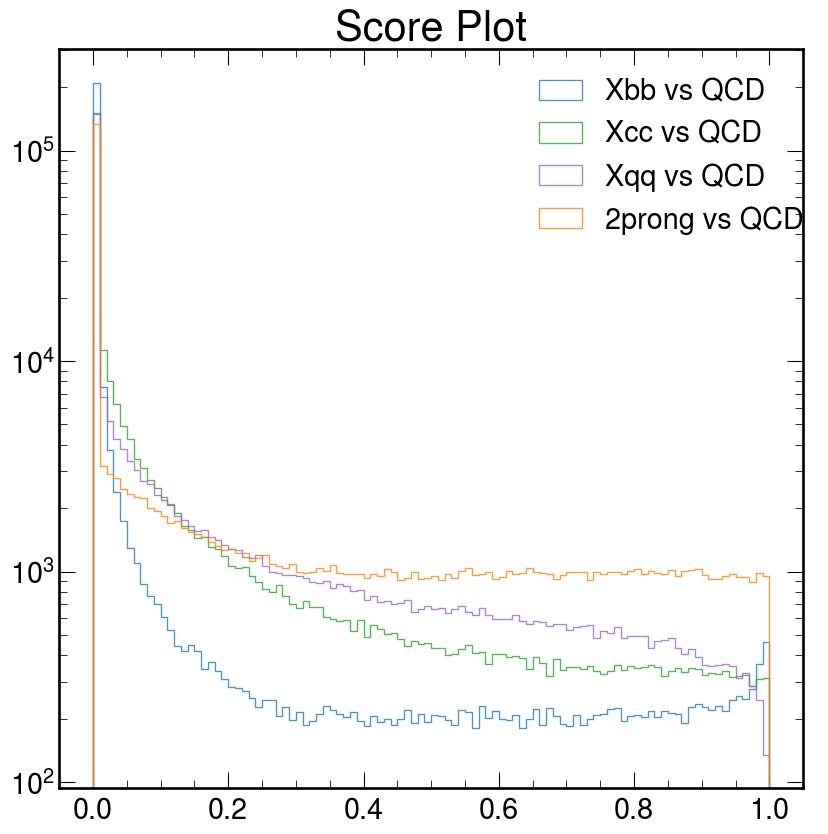

In [19]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}/(pfMassDecorrelatedParticleNetJetTags_prob{sig} + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
        # 'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    # 'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'score' : '(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq)/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
    'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

ScorePlot(algos, title='Score Plot', savename='standard_M150_best_v7_pt110_scores.png')

probXbb,pfMassDecorrelatedParticleNetJetTags_probXbb,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.000000
1         0.000000
2         0.000029
3         0.000120
4         0.000000
            ...   
251528    0.000000
251529    0.000000
251530    0.000000
251531    0.000000
251532    0.000367
Length: 251533, dtype: float32
#1f77b4
-
probXcc,pfMassDecorrelatedParticleNetJetTags_probXcc,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.000000
1         0.000000
2         0.009063
3         0.221023
4         0.000000
            ...   
251528    0.000000
251529    0.000000
251530    0.000000
251531    0.000000
251532    0.041759
Length: 251533, dtype: float32
#2ca02c
-
probXqq,pfMassDecorrelatedParticleNetJetTags_probXqq,fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,251533
prob_score:
0         0.000000
1         0.000000
2        

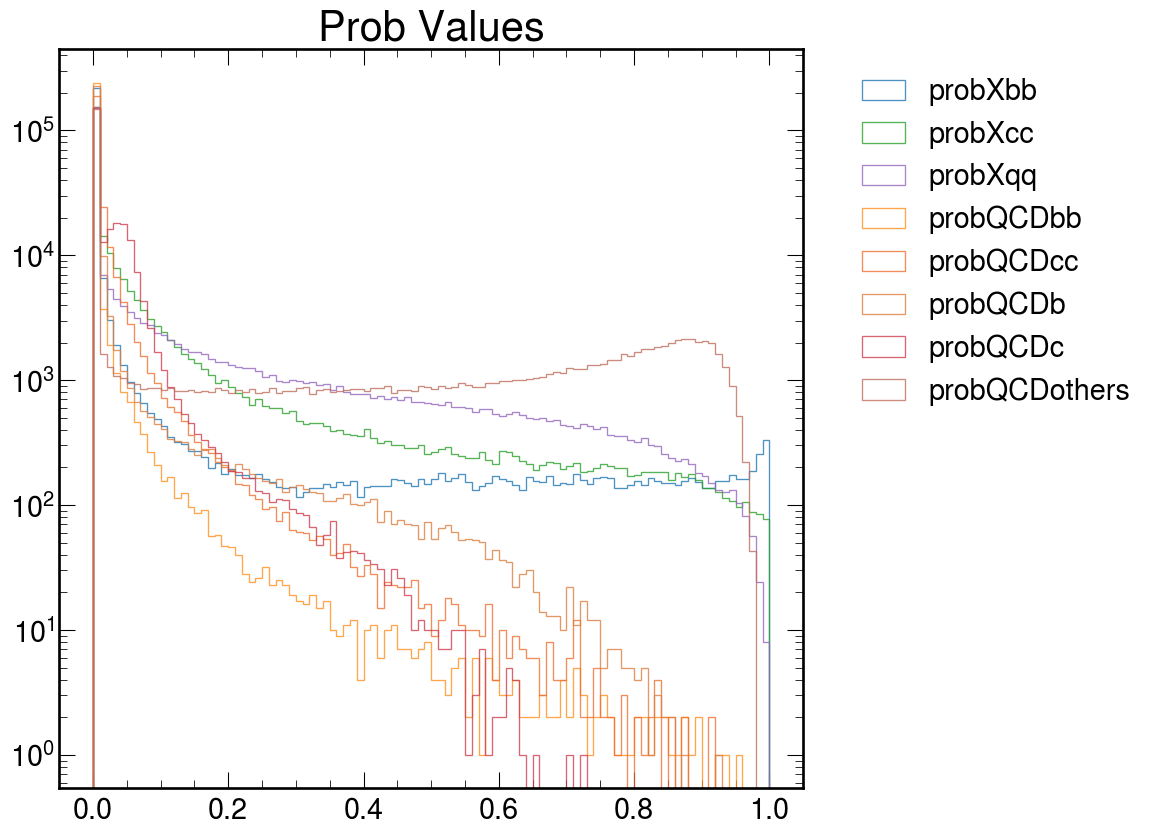

In [20]:
sigs = ["Xbb", "Xcc", "Xqq"]

bkgs = ["bb", "cc", "b", "c", "others"]

algos = {}

for sig in sigs:
    
    algos[f'prob{sig}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }
for bkg in bkgs:
    
    algos[f'probQCD{bkg}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'probQCD{bkg}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_probQCD{bkg}',
        'selection' : 'fj_pt>110 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }


ProbPlot(algos, title='Prob Values', savename='standard_M150_best_v7_pt110_probs.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)', 'selection': 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers),fj_pt>200 & fj_eta>-2.4 &

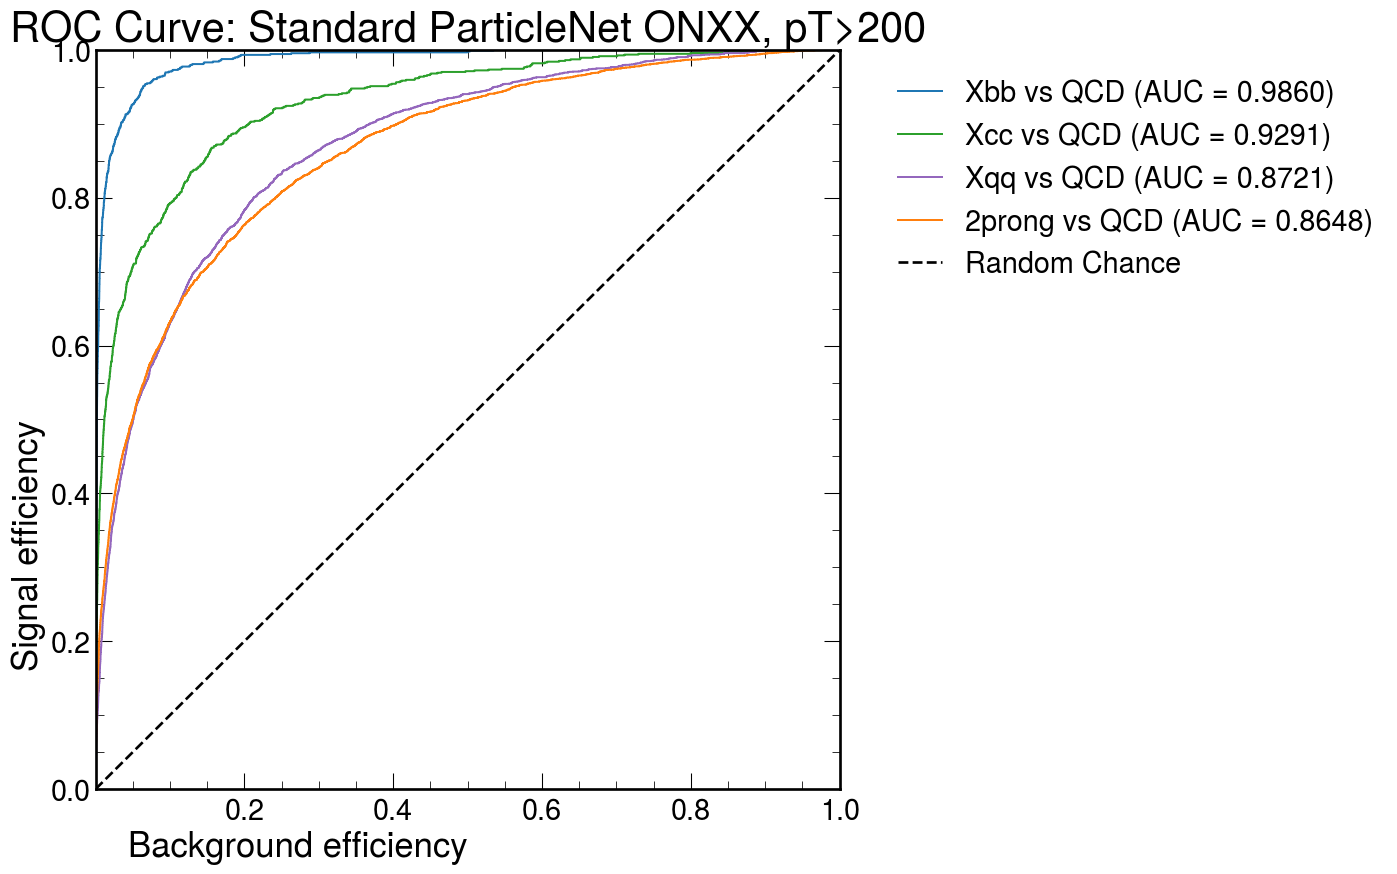

In [21]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        # 'filepath' : '/home/akobert/ParticleNet/training/output/standard6_onnx.root',
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        # 'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}/(pfMassDecorrelatedParticleNetJetTags_prob{sig} + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    # 'filepath' : '/home/akobert/ParticleNet/training/output/standard6_onnx.root',
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    # 'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'score' : '(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq)/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
    'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

plot(algos, title='ROC Curve: Standard ParticleNet ONXX, pT>200', savename='smallTest_M150_best_standard_pt200.png')

Xbb vs QCD
{'filepath': '/home/akobert/ParticleNet/training/output/test7_M150_best.root', 'label': ['probXbb', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'], 'score': 'pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)', 'selection': 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'}
Xbb vs QCD,pfMassDecorrelatedParticleNetJetTags_probXbb/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers),fj_pt>200 & fj_eta>-2.4 &

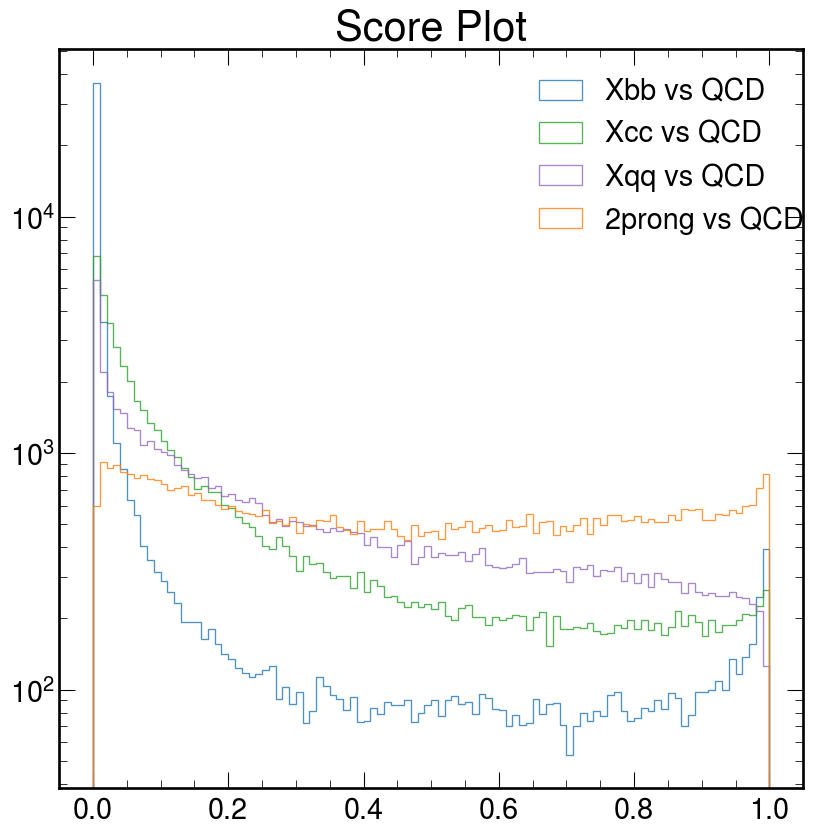

In [22]:
sigs = ["Xbb", "Xcc", "Xqq"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs QCD'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}/(pfMassDecorrelatedParticleNetJetTags_prob{sig} + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
        # 'score' : f'score_prob{sig}/(score_prob{sig} + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }

algos['2prong vs QCD'] = {
    'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',
    'label' : ['probXbb', 'probXcc', 'probXqq', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
    # 'score' : '(score_probXbb + score_probXcc + score_probXqq)/(score_probXbb + score_probXcc + score_probXqq + score_probQCDbb + score_probQCDcc + score_probQCDb + score_probQCDc + score_probQCDothers)',
    'score' : '(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq)/(pfMassDecorrelatedParticleNetJetTags_probXbb + pfMassDecorrelatedParticleNetJetTags_probXcc + pfMassDecorrelatedParticleNetJetTags_probXqq + pfMassDecorrelatedParticleNetJetTags_probQCDbb + pfMassDecorrelatedParticleNetJetTags_probQCDcc + pfMassDecorrelatedParticleNetJetTags_probQCDb + pfMassDecorrelatedParticleNetJetTags_probQCDc + pfMassDecorrelatedParticleNetJetTags_probQCDothers)',
    'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
}

ScorePlot(algos, title='Score Plot', savename='standard_M150_best_v7_pt200_scores.png')

probXbb,pfMassDecorrelatedParticleNetJetTags_probXbb,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.000029
3         0.000120
14        0.000020
16        0.000170
19        0.025133
            ...   
251505    0.003356
251518    0.019879
251519    0.000601
251520    0.008205
251532    0.000367
Length: 56133, dtype: float32
#1f77b4
-
probXcc,pfMassDecorrelatedParticleNetJetTags_probXcc,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.009063
3         0.221023
14        0.048037
16        0.009533
19        0.416758
            ...   
251505    0.059962
251518    0.121258
251519    0.041746
251520    0.168977
251532    0.041759
Length: 56133, dtype: float32
#2ca02c
-
probXqq,pfMassDecorrelatedParticleNetJetTags_probXqq,fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250,56133
prob_score:
2         0.307435
3         0.600689
14        0.31

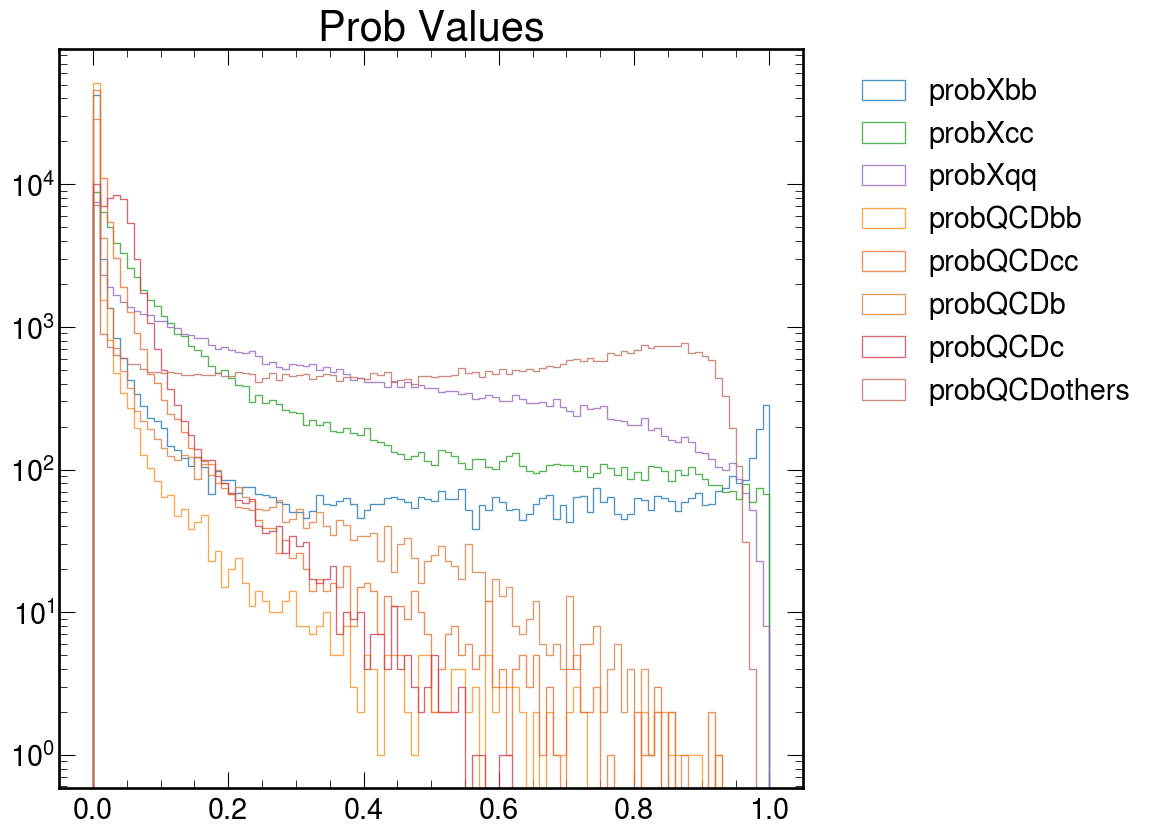

In [23]:
sigs = ["Xbb", "Xcc", "Xqq"]

bkgs = ["bb", "cc", "b", "c", "others"]

algos = {}

for sig in sigs:
    
    algos[f'prob{sig}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'prob{sig}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_prob{sig}',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }
for bkg in bkgs:
    
    algos[f'probQCD{bkg}'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test7_M150_best.root',

        'label' : [f'probQCD{bkg}', 'probQCDbb', 'probQCDcc', 'probQCDb', 'probQCDc', 'probQCDothers'],
        'score' : f'pfMassDecorrelatedParticleNetJetTags_probQCD{bkg}',
        'selection' : 'fj_pt>200 & fj_eta>-2.4 & fj_eta<2.4 & fj_corrsdmass > 1 & fj_corrsdmass < 250'
    }


ProbPlot(algos, title='Prob Values', savename='standard_M150_best_v7_pt200_probs.png')